In [10]:
#import sys
import os
sep = os.sep
# Добавить в путь до родительской папки\n",
#sys.path.append(os.path.join(sys.path[0], f'..{sep}'))
# #sys.path.append(os.path.join(os.getcwd(), f'..{sep}'))

In [35]:
import shutil
import random
from PIL import Image
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
#from torchvision.utils import make_grid

%matplotlib inline

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1 The Eye Glasses Dataset

In [13]:
pass

## 1.1 Download the Dataset

In [14]:
# Download data from https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses/data
# Скачать и распаковать архив в папку '../data/ch05'
# Изображения должны оказаться в папке '../data/ch05/faces-spring-2020/images'

In [15]:
train = pd.read_csv(f'..{os.sep}data{os.sep}ch05{os.sep}train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Columns: 514 entries, id to glasses
dtypes: float64(512), int64(2)
memory usage: 17.6 MB


In [16]:
train.set_index('id', inplace=True)
# 1: Лица с очками; 0: Лица без очков
# id: Название изображения f'face-{id}.png'
train['glasses']

id
1       0
2       1
3       1
4       0
5       0
       ..
4496    0
4497    0
4498    1
4499    1
4500    0
Name: glasses, Length: 4500, dtype: int64

In [28]:
# Очевидно ошибка!
#train.loc[154]['glasses']
#train.loc[242]['glasses']
#train.loc[272]['glasses']
#...
#train.loc[107]['glasses']
#train.loc[195]['glasses']
#train.loc[377]['glasses']
#...

In [51]:
path_name = f'..{sep}data{sep}ch05{sep}glasses'

path_G = f'{path_name}{sep}G'
path_NoG = f'{path_name}{sep}NoG'

os.makedirs(path_G, exist_ok=True)
os.makedirs(path_NoG, exist_ok=True)

In [63]:
# Достаточно запустить один раз
# см. текст ниже

folder = f'..{sep}data{sep}ch05{sep}faces-spring-2020{sep}images'
'''
# Перебираем 4500 изображений и раскидываем по папкам
for i in range(1, 4501):
    old_path = f'{folder}{sep}face-{i}.png'

    if train.loc[i]['glasses'] == 0:
        # Лица без очков
        new_path = f'{path_NoG}{sep}face-{i}.png'
    elif train.loc[i]['glasses'] == 1:
        # Лица с очками
        new_path = f'{path_G}{sep}face-{i}.png'
    
    shutil.copy(old_path, new_path)
'''
pass

**Важно: это неоходимо сделать вручную:**
Столбец классификации *glasses* в файле *train.csv* не идеален. Если перейти, например, в подпапку G на компьютере, увидите, что на большинстве изображений есть очки, но примерно на 10% из них нет очков. Аналогично, если перейти в подпапку NoG, увидите, что примерно на 10% из них действительно есть очки. Вам нужно вручную исправить это, переместив изображения из одной папки в другую. Это важно для обучения. Добро пожаловать в жизнь специалиста по работе с данными: устранение проблем с данными — часть повседневной рутины!

## 1.2 Visualize images in the eyeglasses dataset

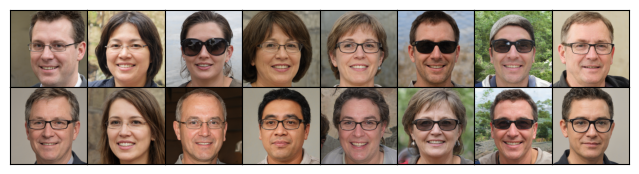

In [56]:
plt.figure(figsize=(8, 2), dpi=100)
#random.seed(42)

imgs = os.listdir(path_G)
samples = random.sample(imgs, 16)

for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    img = Image.open(f'{path_G}{sep}{samples[i]}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(wspace=-0.01,hspace=-0.01)
plt.show();   

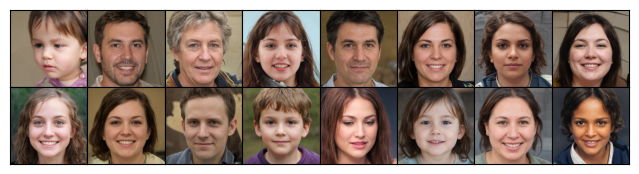

In [88]:
plt.figure(figsize=(8, 2), dpi=100)
#random.seed(42)

imgs = os.listdir(path_NoG)
samples = random.sample(imgs, 16)

for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    img = Image.open(f'{path_NoG}{sep}{samples[i]}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(wspace=-0.01,hspace=-0.01)
plt.show();   

# 2 Conditional GAN wtih Wasserstein Distance

In [89]:
pass

# 3 Create a conditional GAN

In [90]:
pass

## 3.1 A Critic in Conditional GAN

In [61]:
class Critic(nn.Module):
    def __init__(self, img_channels, features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=img_channels, out_channels=features, kernel_size=4, stride=2, padding=1),
            # if x < 0: x = negative_slope*x
            nn.LeakyReLU(negative_slope=0.2)
            
            self.block(features,  features*2, 4, 2, 1),
            self.block(features*2, features*4, 4, 2, 1),
            self.block(features*4, features*8, 4, 2, 1),
            self.block(features*8, features*16, 4, 2, 1),  
            self.block(features*16, features*32, 4, 2, 1),            

            # Оценка между −∞ и ∞. Чем выше оценка, тем больше вероятность,
            # что входные данные взяты из реального набора
            nn.Conv2d(features*32, 1, kernel_size=4, stride=2, padding=0)
        )
    
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride,padding, bias=False,),
            
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(negative_slope=0.2)
        )
        
    def forward(self, x):
        return self.net(x)

## 3.2 The Generator in Conditional GAN

In [64]:
class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, features):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.block(noise_channels, features*64, 4, 1, 0),
            self.block(features*64, features*32, 4, 2, 1),
            self.block(features*32, features*16, 4, 2, 1),
            self.block(features*16, features*8, 4, 2, 1),
            self.block(features*8, features*4, 4, 2, 1),            
            self.block(features*4, features*2, 4, 2, 1),            
        
            nn.ConvTranspose2d(
                in_channels=features*2, out_channels=img_channels, kernel_size=4, stride=2, padding=1
            ),
            
            # Сжать каждое число на выходе до диапазона [-1.0, 1.0]
            # - как у тренировочных данных
            nn.Tanh()
        )
        
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False,),
            # Нормализация выполняется независимо для каждого цветового канала
            # путем корректировки и масштабирования значений в канале таким образом,
            # чтобы они имели среднее значение 0 и дисперсию 1
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

## 3.3 Weight initialization and the gradient penalty function

In [70]:
def weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)    

In [71]:
z_dim = 100
img_channels = 3
features = 16

gen = Generator(z_dim+2, img_channels, features).to(device)

# Первые три канала — это цветовые каналы (цвета красный, зеленый и синий).
# Последние два канала (четвертый и пятый каналы) — это каналы меток, лицо в очках или без
critic = Critic(img_channels+2, features).to(device)

weights_init(gen)
weights_init(critic)

In [72]:
lr = 0.0001
# betas: Контролируем, насколько большое внимание уделяется
# недавней по сравнению с прошлой информацией о градиенте
# 0.0: past gradient information
# 0.9: recent gradient information
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

In [73]:
def GP(critic, real, fake):
    B, C, H, W = real.shape
    alpha = torch.rand((B, 1, 1, 1)).repeat(1, C, H, W).to(device)
    
    interpolated_images = real*alpha + fake*(1-alpha)
    critic_scores = critic(interpolated_images)
    
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=critic_scores,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gp = torch.mean((gradient_norm - 1) ** 2)
    
    return gp

# 4 Train the conditional GAN

In [74]:
pass

## 4.1 Adding labels to inputs

In [76]:
imgsz = 256
transform = T.Compose([
    # Все изображения привести к одному размеру 64х64
    T.Resize((imgsz, imgsz)),
    # Converts image pixels to PyTorch tensors
    # From range [0, 255] to range [0.0, 1.0]
    T.ToTensor(),
    # Normalizes the values to the range [–1.0, 1.0]
    # Вычитаем 0.5 из данных и разделить разницу на 0.5
    # В каждом массиве 3 числа - по одному на каждый цветовой канал
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Нормализация входных данных до диапазона [–1, 1]
# позволяет градиентному спуску работать более эффективно

In [81]:
data_set = ImageFolder(
    root=f'..{sep}data{sep}ch05{sep}glasses',
    transform=transform
)

In [80]:
new_data = []

for i, (img, label) in enumerate(data_set):
    onehot = torch.zeros((2))
    onehot[label] = 1
    
    channels = torch.zeros((2, imgsz, imgsz))
    if label == 0:
        channels[0, :, :] = 1
    else:
        channels[1, :, :] = 1    

    img_and_label = torch.cat([img, channels], dim=0)    
    new_data.append((img, label, onehot, img_and_label))

In [82]:
batch_size = 16

data_loader = DataLoader(new_data, batch_size=batch_size, shuffle=True)

## 4.2 Train the Conditional GAN

In [83]:
def plot_epoch(epoch):
    # test images with glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)

    # use label [1, 0] so G knows what to generate
    labels[:, 0, :, :] = 1
    noise_and_labels = torch.cat([noise, labels], dim=1).to(device)
    fake = gen(noise_and_labels).cpu().detach()
    
    fig = plt.figure(figsize=(20, 10), dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img = (fake[i]/2 + 0.5).permute(1, 2, 0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f'files{sep}img_glasses{sep}G{epoch}.png')
    plt.show();
    
    # test images without glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    
    # use label [0,1] so G knows what to generate
    labels[:, 1, :, :] = 1
    noise_and_labels = torch.cat([noise, labels], dim=1).to(device)
    fake = gen(noise_and_labels).cpu().detach()
    
    fig = plt.figure(figsize=(20, 10), dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake[i]/2 + 0.5).permute(1, 2, 0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f'files{sep}img_glasses{sep}NoG{epoch}.png')
    plt.show();

In [84]:
def train_batch(onehots, img_and_labels, epoch):
    real = img_and_labels.to(device)
    B = real.shape[0]
    
    # train critic five times
    for _ in range(5):
        noise = torch.randn(B, z_dim, 1, 1)
        onehots = onehots.reshape(B, 2, 1, 1)
        noise_and_labels = torch.cat([noise, onehots], dim=1).to(device)
        
        fake_img = gen(noise_and_labels).to(device)
        fakelabels = img_and_labels[:, 3:, :, :].to(device)
        fake = torch.cat([fake_img, fakelabels], dim=1).to(device)
        
        critic_real = critic(real).reshape(-1)
        critic_fake = critic(fake).reshape(-1)
        
        gp = GP(critic, real, fake)
        loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + 10 * gp)
        
        opt_critic.zero_grad()
        loss_critic.backward(retain_graph=True)
        opt_critic.step()
    
    # train G
    gen_fake = critic(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    opt_gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    
    return loss_critic, loss_gen

In [86]:
n_epoch = 100
for epoch in range(1, n_epoch+1):
    closs=0
    gloss=0
    for _ , _, onehots, img_and_labels in data_loader:    
        # train a batch
        loss_critic, loss_gen = train_batch(onehots, img_and_labels,epoch)   
        closs += loss_critic.detach() / len(data_loader)
        gloss += loss_gen.detach()/len(data_loader)

    if epoch % 20 == 0:
        print(f'At epoch {epoch} => critic loss: {closs:.6f}; generator loss {gloss:.6f}')
        plot_epoch(epoch)
    else:
        print(epoch, end=', ')

torch.save(gen.state_dict(), f'files{sep}cgan.pth')

KeyboardInterrupt: 

# 5 Select characteristics in generated images

In [87]:
pass

## 5.1 Select images with or without eyeglasses